In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import vgg16_bn, resnet18
#from keras import layers

### 資料讀取以及標記

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root, filenames):
        self.image_root = root
        self.filenames = filenames
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        label_map = {}
        for i in self.filenames:
            if 'imgN' in i:
                label_map['{}'.format(i)] = 0
            else:
                label_map['{}'.format(i)] = 1
        self.labels = [label_map[filename] for filename in self.filenames]

        del label_map
        gc.collect()

    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, index):
        filename = self.filenames[index]
        image_path = os.path.join(self.image_root, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        label = self.labels[index]
        return image, label

In [3]:
workspace = "E:\garypython\AutismDataset"
train_root_old = os.path.join(workspace, "train")
filenames_old = [filename for filename in os.listdir(train_root_old)]  

a = 1
b = 1
for i in os.listdir(train_root_old):
    pt = os.path.join(train_root_old , i)
    if 'Non_Autistic' in i:
        Imges = cv2.imread(pt, cv2.IMREAD_GRAYSCALE)
        #Imges = cv2.GaussianBlur(Imges, (7, 7), 1)
        cv2.imwrite(workspace + "/new_train/imgN.{}.jpg".format(a), Imges)
        a += 1
    else:
        Imges = cv2.imread(pt, cv2.IMREAD_GRAYSCALE)
        #Imges = cv2.GaussianBlur(Imges, (7, 7), 1)
        cv2.imwrite(workspace + "/new_train/imgA.{}.jpg".format(b), Imges)
        b += 1

del filenames_old
gc.collect()    

0

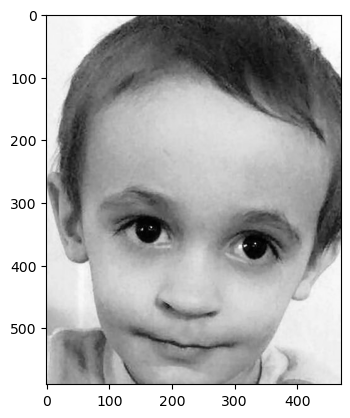

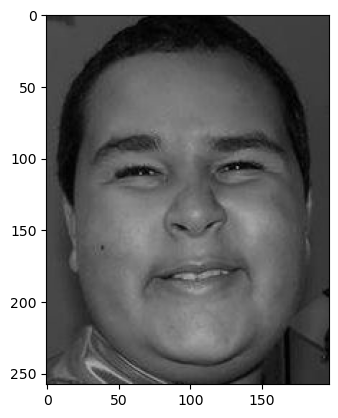

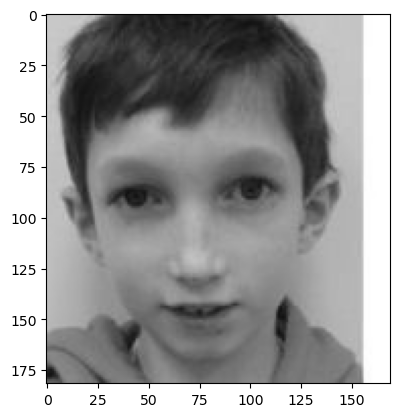

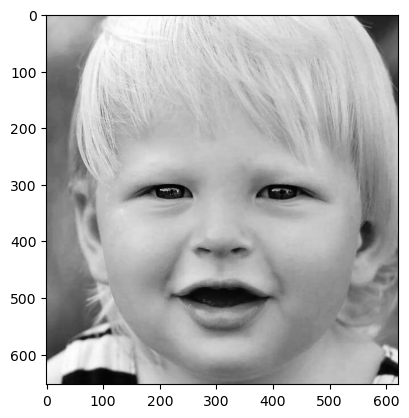

In [4]:
train_root_new = os.path.join(workspace, "new_train")

k = 0
for i in os.listdir(train_root_new):
    pt = os.path.join(train_root_new , i)
    Imges = img.imread(pt)
    Imges = cv2.cvtColor(Imges, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(Imges)
    k += 1
    plt.show()
    if k > 3:
        break

In [28]:
train_root_new = os.path.join(workspace, "new_train")
filenames_new = [filename for filename in os.listdir(train_root_new)]

train_filenames = filenames_new[:int(len(filenames_new)*0.8)]
valid_filenames = filenames_new[int(len(filenames_new)*0.8):]

train_dataset = CustomDataset(train_root_new, train_filenames)
valid_dataset = CustomDataset(train_root_new, valid_filenames)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [13]:
#vit_b_16模型物件
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.vit = models.vision_transformer.vit_b_16(pretrained=True)
        self.classfile = nn.Linear(1000, 2)
        
    def forward(self, x):
        out = self.vit(x)
        out = self.classfile(out)
        return out

In [25]:
#自創模型物件
class ClassificationModel2(nn.Module):
    def __init__(self):
            super(ClassificationModel2, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3))
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
            self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
            self.dropout = nn.Dropout(0.25)
            
            self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
            self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3))
            
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(86528, 64)
            self.fc2 = nn.Linear(64, 2)
            self.relu = nn.ReLU()
            

    def forward(self, x):
            x = self.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            x = self.maxpool(x)
            x = self.dropout(x)

            x = self.relu(self.conv3(x))
            x = self.maxpool(x)
        

            x = self.relu(self.conv4(x))
            x = self.maxpool(x)
            

            x = self.flatten(x)
            x = self.fc1(x)
            x = self.fc2(x)
            return x

In [31]:
#VGG16
class ClassificationModel3(nn.Module):
    def __init__(self):
        super(ClassificationModel3, self).__init__()
        self.vgg_16 = vgg16_bn(pretrained=True)
        self.classfile = nn.Linear(1000, 2)
        
    def forward(self, x):
        out = self.vgg_16(x)
        out = self.classfile(out)
        return out

In [20]:
#resnet18
class ClassificationModel4(nn.Module):
    def __init__(self):
        super(ClassificationModel4, self).__init__()
        self.rn18 = resnet18(pretrained=True)
        self.classfile = nn.Linear(1000, 2)
        
    def forward(self, x):
        out = self.rn18(x)
        out = self.classfile(out)
        return out

In [7]:
#early_stop1
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
del EarlyStopper
gc.collect()

## 使用 vision transformer 的 vit_b_16 模型

In [12]:
#郭禹辰模型
device = 'cuda'
num_epoch = 10

model = ClassificationModel()
#model.load_state_dict(torch.load('best_weight (1).pt'))
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

best_accuracy = 0.0
early_stopper = EarlyStopper(patience=3, min_delta=10)

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(num_epoch):
    train_loss = 0.0
    correct, total = 0, 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 

        batch_loss = loss(outputs, labels)
        batch_loss.backward() #讓我CUDA不會爆掉
        optimizer.step() #改權重

        train_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
        total += images.shape[0]
    train_accuracy = correct / total * 100
    train_loss_list.append(train_loss/len(train_loader))
    train_acc_list.append(train_accuracy)

    valid_loss = 0.0
    correct, total = 0, 0
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
          
        batch_loss = loss(outputs, labels)
        valid_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()
        total += images.shape[0]
    valid_accuracy = correct / total * 100
    valid_loss_list.append(valid_loss/len(valid_loader))
    valid_acc_list.append(valid_accuracy)

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_weight_vit.pt")
                                                       
    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    if early_stopper.early_stop(valid_loss):             
        break


NameError: name 'ClassificationModel' is not defined

In [55]:
data = {'train_loss': train_loss_list, 'train_accuracy': train_acc_list, 'valid_loss': valid_loss_list, 'valid_accuracy': valid_acc_list}
df = pd.DataFrame(data)
print(df)

   train_loss  train_accuracy  valid_loss  valid_accuracy
0    0.479363       77.559055    0.740954       59.645669
1    0.305466       87.746063    0.691494       66.535433
2    0.198326       92.765748    1.128878       51.574803
3    0.103828       96.998031    1.056461       63.582677
4    0.040417       99.261811    0.497457       84.645669
5    0.024091       99.311024    0.917813       73.425197
6    0.017779       99.704724    1.623371       61.220472
7    0.129710       94.881890    1.415900       56.692913
8    0.022068       99.458661    1.816302       57.283465


Text(0.5, 1.0, 'Training and Validation Accuracy')

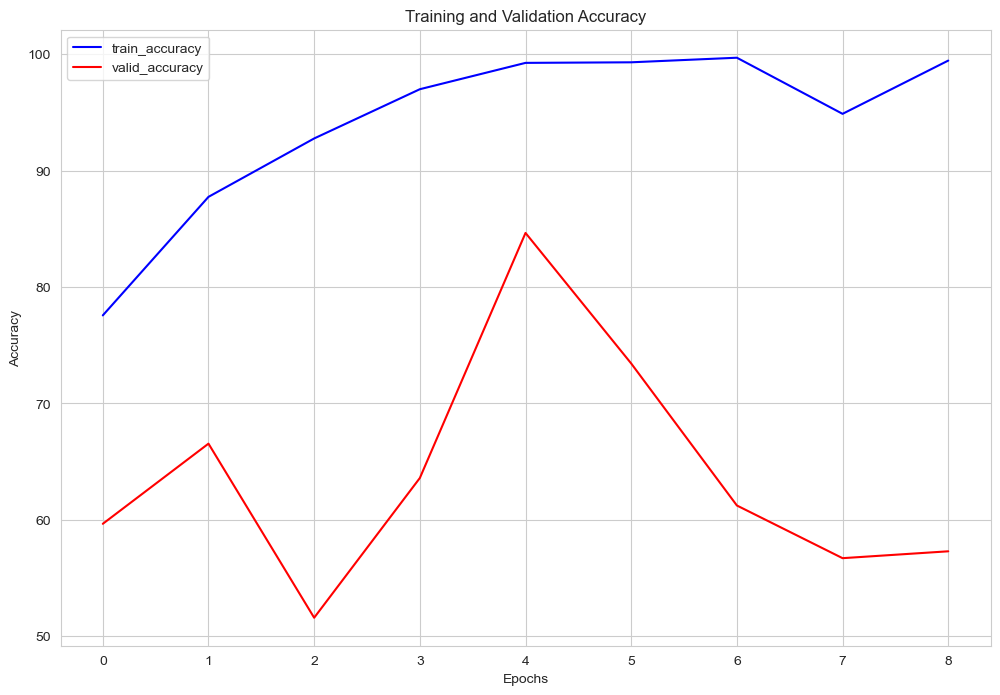

In [56]:
# Plot train and validation accuracy
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_accuracy", "valid_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

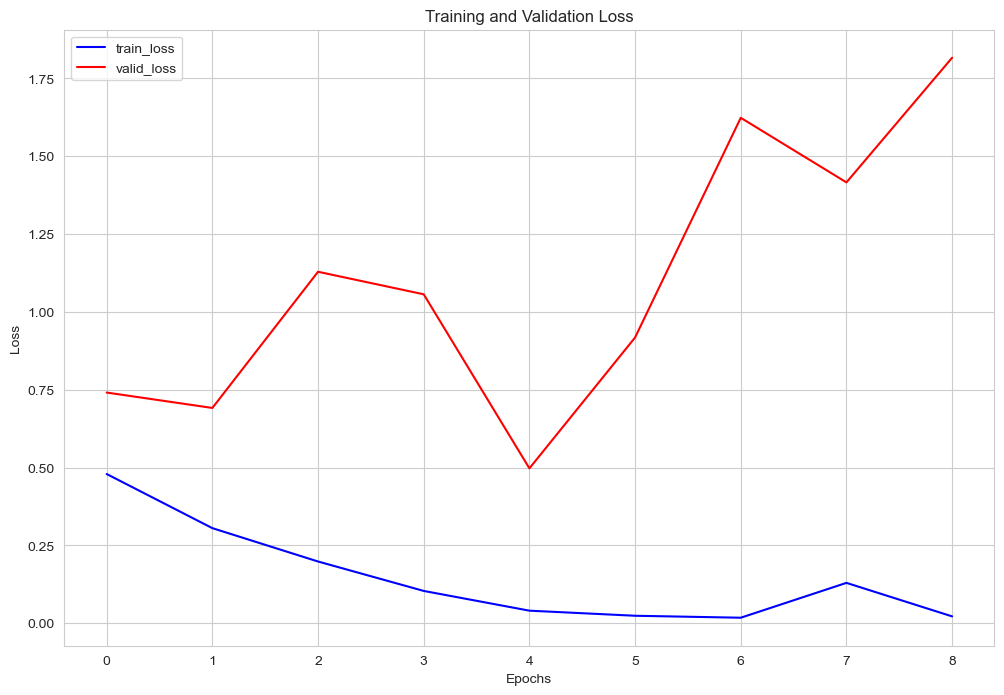

In [57]:
# Plot train and validation Loss
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_loss", "valid_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

## 使用自創模型

In [36]:
#石敏俊模型
device = 'cuda'
num_epoch = 10

model = ClassificationModel2()
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

best_accuracy2 = 0.0
early_stopper2 = EarlyStopper(patience=3, min_delta=10)

train_loss_list1 = []
valid_loss_list1 = []
train_acc_list1 = []
valid_acc_list1 = []
for epoch in range(num_epoch):
    train_loss = 0.0
    correct, total = 0, 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer2.zero_grad()
        outputs2 = model(images) 

        batch_loss = loss(outputs2, labels)
        batch_loss.backward() #讓我CUDA不會爆掉
        optimizer2.step() #改權重

        train_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs2, dim=1) == labels).item()#判讀結果，正確就加1
        total += images.shape[0]
    train_accuracy = correct / total * 100
    train_loss_list1.append(train_loss/len(train_loader))
    train_acc_list1.append(train_accuracy)

    valid_loss = 0.0
    correct, total = 0, 0
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs2 = model(images)
          
        batch_loss = loss(outputs2, labels)
        valid_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs2, dim=1) == labels).item()
        total += images.shape[0]
    valid_accuracy = correct / total * 100
    valid_loss_list1.append(valid_loss/len(valid_loader))
    valid_acc_list1.append(valid_accuracy)

    if valid_accuracy > best_accuracy2:
        best_accuracy2 = valid_accuracy
        torch.save(model.state_dict(), "best_weight2.pt")
                                                       
    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    if early_stopper2.early_stop(valid_loss):             
        break


Epoch [1/10] - Train Loss: 0.6312, Train Accuracy: 64.96%, Valid Loss: 0.8144, Valid Accuracy: 24.61%
Epoch [2/10] - Train Loss: 0.5687, Train Accuracy: 72.93%, Valid Loss: 0.8825, Valid Accuracy: 38.39%
Epoch [3/10] - Train Loss: 0.5415, Train Accuracy: 74.90%, Valid Loss: 0.8818, Valid Accuracy: 41.93%
Epoch [4/10] - Train Loss: 0.5288, Train Accuracy: 74.80%, Valid Loss: 0.9269, Valid Accuracy: 38.19%
Epoch [5/10] - Train Loss: 0.5081, Train Accuracy: 77.07%, Valid Loss: 0.8200, Valid Accuracy: 48.82%
Epoch [6/10] - Train Loss: 0.4949, Train Accuracy: 76.82%, Valid Loss: 0.7379, Valid Accuracy: 55.12%
Epoch [7/10] - Train Loss: 0.4903, Train Accuracy: 77.46%, Valid Loss: 0.9051, Valid Accuracy: 43.50%
Epoch [8/10] - Train Loss: 0.4796, Train Accuracy: 78.30%, Valid Loss: 0.8408, Valid Accuracy: 48.03%
Epoch [9/10] - Train Loss: 0.4740, Train Accuracy: 78.30%, Valid Loss: 0.7268, Valid Accuracy: 55.31%
Epoch [10/10] - Train Loss: 0.4768, Train Accuracy: 78.54%, Valid Loss: 0.7466, Va

In [37]:
data1 = {'train_loss': train_loss_list1, 'train_accuracy': train_acc_list1, 'valid_loss': valid_loss_list1, 'valid_accuracy': valid_acc_list1}
df1 = pd.DataFrame(data1)
print(df1)

   train_loss  train_accuracy  valid_loss  valid_accuracy
0    0.631243       64.960630    0.814422       24.606299
1    0.568720       72.933071    0.882538       38.385827
2    0.541458       74.901575    0.881780       41.929134
3    0.528772       74.803150    0.926863       38.188976
4    0.508071       77.066929    0.819983       48.818898
5    0.494879       76.820866    0.737873       55.118110
6    0.490252       77.460630    0.905060       43.503937
7    0.479609       78.297244    0.840785       48.031496
8    0.473999       78.297244    0.726786       55.314961
9    0.476755       78.543307    0.746646       54.724409


In [ ]:
# Plot train and validation accuracy
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_accuracy", "valid_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [ ]:
# Plot train and validation Loss
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_loss", "valid_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

## 使用VGG16模型

In [33]:
#VGG16
device = 'cuda'
num_epoch = 10

model = ClassificationModel3()
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

best_accuracy = 0.0
early_stopper = EarlyStopper(patience=3, min_delta=10)

train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []
for epoch in range(num_epoch):
    train_loss = 0.0
    correct, total = 0, 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 

        batch_loss = loss(outputs, labels)
        batch_loss.backward() #讓我CUDA不會爆掉
        optimizer.step() #改權重

        train_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
        total += images.shape[0]
    train_accuracy = correct / total * 100
    train_loss_list.append(train_loss/len(train_loader))
    train_acc_list.append(train_accuracy)

    valid_loss = 0.0
    correct, total = 0, 0
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
          
        batch_loss = loss(outputs, labels)
        valid_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()
        total += images.shape[0]
    valid_accuracy = correct / total * 100
    valid_loss_list.append(valid_loss/len(valid_loader))
    valid_acc_list.append(valid_accuracy)

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_weight_VGG16.pt")
                                                       
    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    if early_stopper.early_stop(valid_loss):             
        break

Epoch [1/10] - Train Loss: 0.5375, Train Accuracy: 73.38%, Valid Loss: 0.9082, Valid Accuracy: 51.57%
Epoch [2/10] - Train Loss: 0.2908, Train Accuracy: 88.48%, Valid Loss: 1.0527, Valid Accuracy: 53.54%
Epoch [3/10] - Train Loss: 0.1444, Train Accuracy: 95.18%, Valid Loss: 1.0893, Valid Accuracy: 57.09%
Epoch [4/10] - Train Loss: 0.0636, Train Accuracy: 98.43%, Valid Loss: 1.1803, Valid Accuracy: 61.42%
Epoch [5/10] - Train Loss: 0.0323, Train Accuracy: 99.46%, Valid Loss: 1.6941, Valid Accuracy: 52.95%
Epoch [6/10] - Train Loss: 0.0198, Train Accuracy: 99.70%, Valid Loss: 1.4050, Valid Accuracy: 60.83%
Epoch [7/10] - Train Loss: 0.0168, Train Accuracy: 99.61%, Valid Loss: 0.8357, Valid Accuracy: 75.20%
Epoch [8/10] - Train Loss: 0.0079, Train Accuracy: 100.00%, Valid Loss: 1.7741, Valid Accuracy: 57.48%
Epoch [9/10] - Train Loss: 0.0066, Train Accuracy: 99.90%, Valid Loss: 1.6941, Valid Accuracy: 60.24%
Epoch [10/10] - Train Loss: 0.0059, Train Accuracy: 99.95%, Valid Loss: 1.9347, V

In [38]:
data = {'train_loss': train_loss_list, 'train_accuracy': train_acc_list, 'valid_loss': valid_loss_list, 'valid_accuracy': valid_acc_list}
df = pd.DataFrame(data)
print(df)

   train_loss  train_accuracy  valid_loss  valid_accuracy
0    0.537453       73.375984    0.908174       51.574803
1    0.290841       88.484252    1.052683       53.543307
2    0.144366       95.177165    1.089254       57.086614
3    0.063605       98.425197    1.180320       61.417323
4    0.032282       99.458661    1.694140       52.952756
5    0.019764       99.704724    1.404991       60.826772
6    0.016792       99.606299    0.835693       75.196850
7    0.007909      100.000000    1.774069       57.480315
8    0.006623       99.901575    1.694145       60.236220
9    0.005903       99.950787    1.934743       56.102362


Text(0.5, 1.0, 'Training and Validation Accuracy')

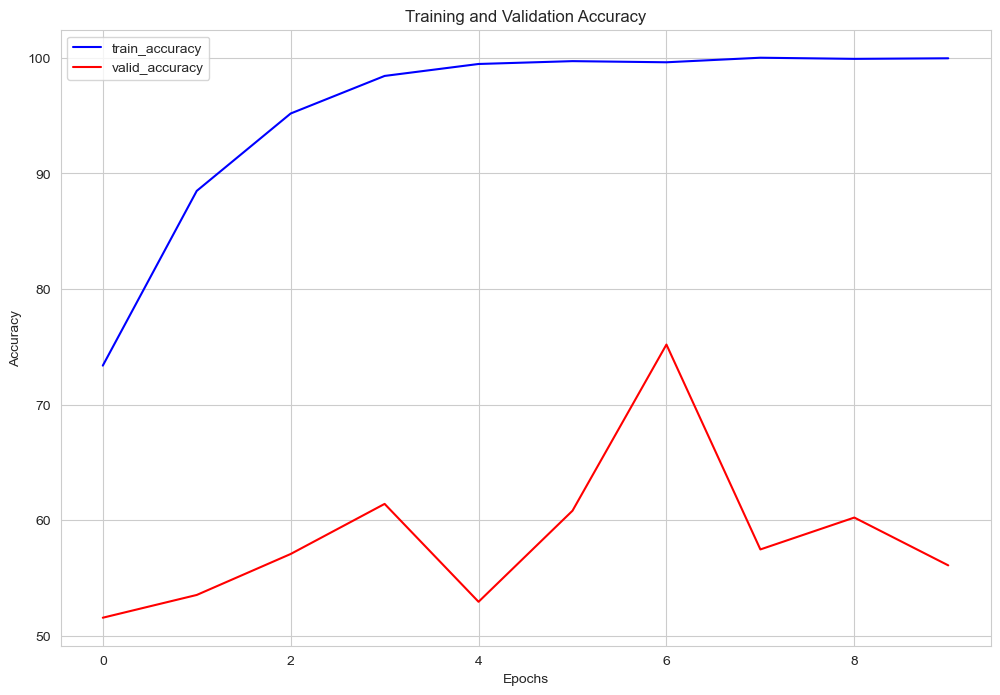

In [39]:
# Plot train and validation accuracy
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_accuracy", "valid_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

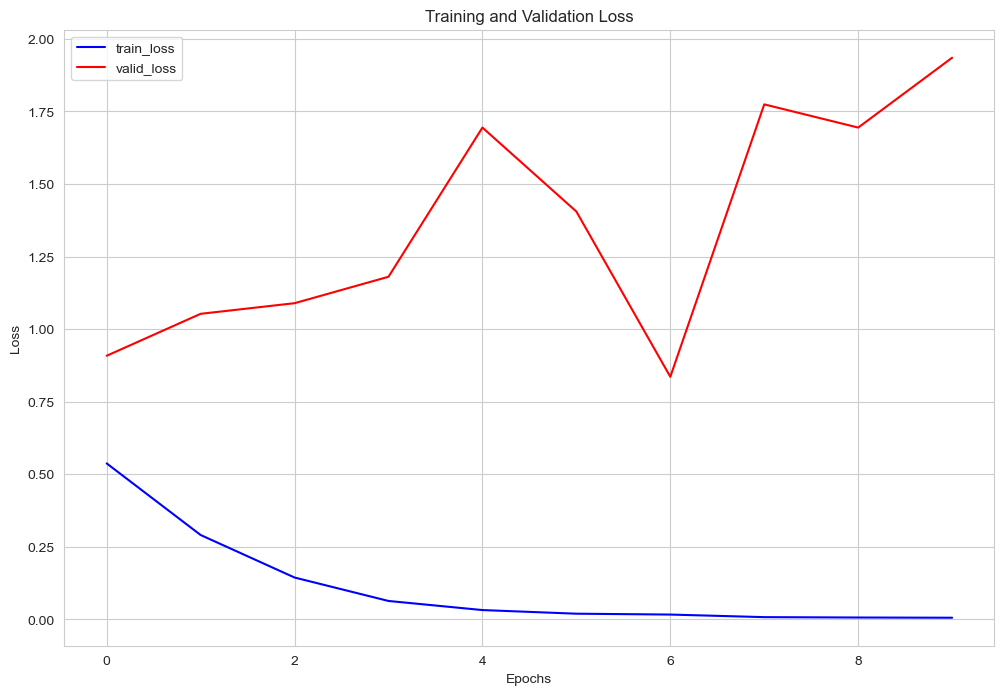

In [40]:
# Plot train and validation Loss
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_loss", "valid_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [ ]:
# Plot train and validation accuracy
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_accuracy", "valid_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [ ]:
# Plot train and validation Loss
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_loss", "valid_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

## 使用 resnet18 模型

In [43]:
device = 'cuda'
num_epoch = 10

model = ClassificationModel4()
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

best_accuracy = 0.0
early_stopper = EarlyStopper(patience=3, min_delta=10)

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(num_epoch):
    train_loss = 0.0
    correct, total = 0, 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 

        batch_loss = loss(outputs, labels)
        batch_loss.backward() #讓我CUDA不會爆掉
        optimizer.step() #改權重

        train_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
        total += images.shape[0]
    train_accuracy = correct / total * 100
    train_loss_list.append(train_loss/len(train_loader))
    train_acc_list.append(train_accuracy)

    valid_loss = 0.0
    correct, total = 0, 0
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
          
        batch_loss = loss(outputs, labels)
        valid_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()
        total += images.shape[0]
    valid_accuracy = correct / total * 100
    valid_loss_list.append(valid_loss/len(valid_loader))
    valid_acc_list.append(valid_accuracy)

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_weight_RN18.pt")
                                                       
    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    if early_stopper.early_stop(valid_loss):             
        break

c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Train Loss: 0.5413, Train Accuracy: 74.21%, Valid Loss: 1.0642, Valid Accuracy: 41.73%
Epoch [2/10] - Train Loss: 0.3299, Train Accuracy: 86.22%, Valid Loss: 0.9968, Valid Accuracy: 49.61%
Epoch [3/10] - Train Loss: 0.2465, Train Accuracy: 91.24%, Valid Loss: 1.0006, Valid Accuracy: 50.59%
Epoch [4/10] - Train Loss: 0.1683, Train Accuracy: 95.47%, Valid Loss: 1.0187, Valid Accuracy: 52.17%
Epoch [5/10] - Train Loss: 0.1258, Train Accuracy: 97.83%, Valid Loss: 0.9790, Valid Accuracy: 56.69%
Epoch [6/10] - Train Loss: 0.0839, Train Accuracy: 98.82%, Valid Loss: 1.1369, Valid Accuracy: 53.94%
Epoch [7/10] - Train Loss: 0.0595, Train Accuracy: 99.61%, Valid Loss: 1.1737, Valid Accuracy: 54.92%
Epoch [8/10] - Train Loss: 0.0445, Train Accuracy: 99.80%, Valid Loss: 1.1444, Valid Accuracy: 57.68%
Epoch [9/10] - Train Loss: 0.0341, Train Accuracy: 99.90%, Valid Loss: 1.0642, Valid Accuracy: 59.84%
Epoch [10/10] - Train Loss: 0.0211, Train Accuracy: 100.00%, Valid Loss: 1.4044, V

In [44]:
data = {'train_loss': train_loss_list, 'train_accuracy': train_acc_list, 'valid_loss': valid_loss_list, 'valid_accuracy': valid_acc_list}
df = pd.DataFrame(data)
print(df)

   train_loss  train_accuracy  valid_loss  valid_accuracy
0    0.541269       74.212598    1.064174       41.732283
1    0.329929       86.220472    0.996764       49.606299
2    0.246451       91.240157    1.000598       50.590551
3    0.168254       95.472441    1.018662       52.165354
4    0.125808       97.834646    0.978986       56.692913
5    0.083873       98.818898    1.136855       53.937008
6    0.059490       99.606299    1.173653       54.921260
7    0.044497       99.803150    1.144387       57.677165
8    0.034052       99.901575    1.064226       59.842520
9    0.021107      100.000000    1.404446       53.543307


Text(0.5, 1.0, 'Training and Validation Accuracy')

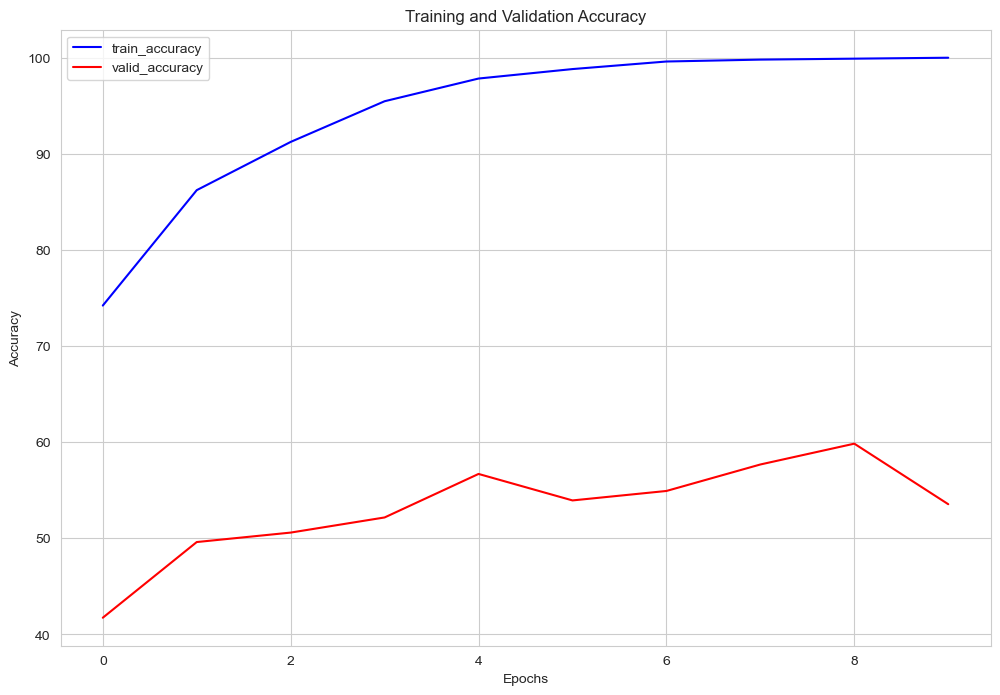

In [45]:
# Plot train and validation accuracy
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_accuracy", "valid_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

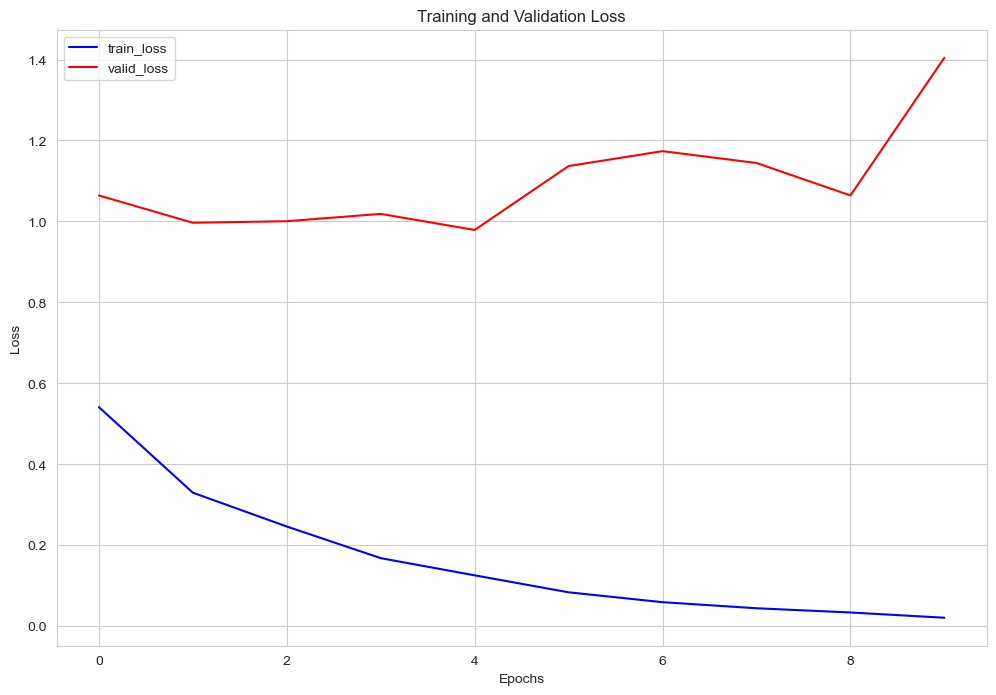

In [46]:
# Plot train and validation Loss
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=df.loc[:, ["train_loss", "valid_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

## Test 資料及測試

In [1]:
del filenames_new
del train_filenames
del valid_filenames
del train_dataset
del valid_dataset
del train_loader
del valid_loader
gc.collect()

NameError: name 'filenames_new' is not defined

In [7]:
class CustomDataset1(Dataset):
    def __init__(self, root, filenames, label_map):
        self.image_root = root
        self.filenames = filenames
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.labels = [label_map[filename] for filename in self.filenames]

    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, index):
        filename = self.filenames[index]
        image_path = os.path.join(self.image_root, filename)
        image = cv2.imread(image_path)
        image = self.transform(image)
        label = self.labels[index]
        return image, label



In [8]:
workspace = "E:\garypython\AutismDataset"
test_root = os.path.join(workspace, "test")
test_filenames = [filename for filename in os.listdir(test_root)]  

label_test = {}
for i in os.listdir(test_root):
    #pt = os.path.join(test_root , i)
    if 'Non_Autistic' in i:
        label_test['{}'.format(i)] = 0    
    else:
        label_test['{}'.format(i)] = 1
#del filenames_old
#gc.collect()

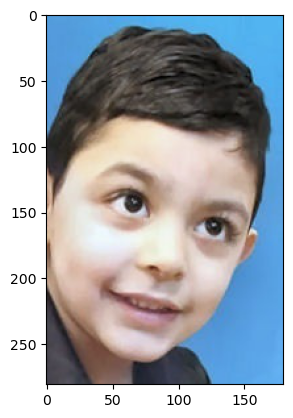

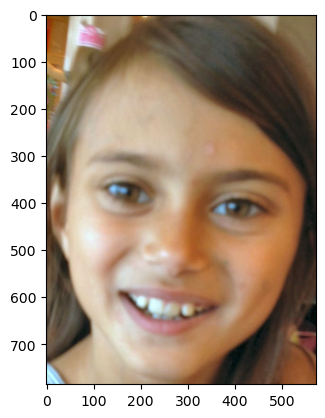

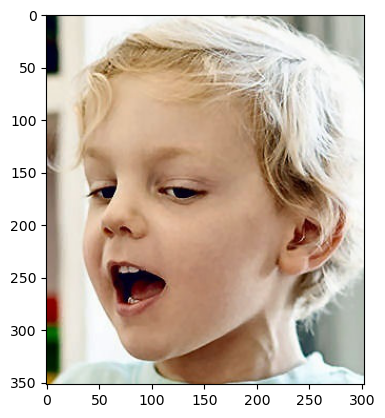

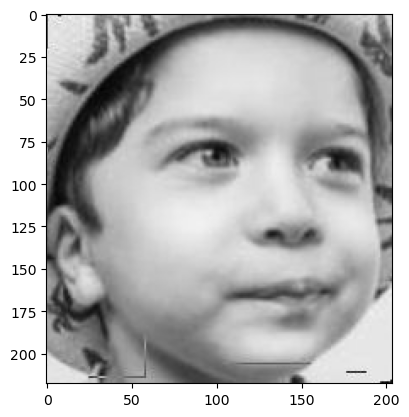

In [9]:
k = 0
for i in os.listdir(test_root):
    pt = os.path.join(test_root , i)
    Imges = img.imread(pt)
    imgplot = plt.imshow(Imges)
    k += 1
    plt.show()
    if k > 3:
        break

In [10]:
test_dataset = CustomDataset1(test_root, test_filenames, label_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
del test_filenames
#del label_test
#gc.collect()

In [24]:
#vit_b_16
device = 'cuda'
model = ClassificationModel()
model.to(device)
model.load_state_dict(torch.load('best_weight (1).pt'))
model.eval()
correct, total = 0, 0
predict = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 
    correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
    a = torch.argmax(outputs, dim=1).tolist()
    for i in range(len(a)):
        predict.append(a[i])
    total += images.shape[0]
test_accuracy = correct / total * 100
                                                    
print(f"Test Accuracy: {test_accuracy:.2f}%")

c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 83.00%


In [26]:
#自創模型
from torch import dtype
device = 'cuda'
model = ClassificationModel2()
model.to(device)
model.load_state_dict(torch.load('best_weight2.pt'))
model.eval()
correct, total = 0, 0
predict1 = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 
    correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
    a = torch.argmax(outputs, dim=1).tolist()
    for i in range(len(a)):
        predict1.append(a[i])
    total += images.shape[0]
test_accuracy = correct / total * 100
                                                    
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 71.00%


In [41]:
#VGG16
device = 'cuda'
model = ClassificationModel3()
model.to(device)
model.load_state_dict(torch.load('best_weight_VGG16.pt'))
model.eval()
correct, total = 0, 0
predict = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 
    correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
    a = torch.argmax(outputs, dim=1).tolist()
    for i in range(len(a)):
        predict.append(a[i])
    total += images.shape[0]
test_accuracy = correct / total * 100
                                                    
print(f"Test Accuracy: {test_accuracy:.2f}%")

c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 48.00%


In [21]:
#RESNET18
device = 'cuda'
model = ClassificationModel4()
model.to(device)
model.load_state_dict(torch.load('best_weight_RN18.pt'))
model.eval()
correct, total = 0, 0
predict = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 
    correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
    a = torch.argmax(outputs, dim=1).tolist()
    for i in range(len(a)):
        predict.append(a[i])
    total += images.shape[0]
test_accuracy = correct / total * 100     
print(f"Test Accuracy: {test_accuracy:.2f}%")

c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 51.00%


In [25]:
import pandas as pd
from pathlib import Path
#filepath = Path('E:\garypython\AutismDataset\ADM.csv') 
test = pd.DataFrame(data = predict, columns = ["predictions"])
test
test["filename"] = label_test
test_labels = []
for key, value in label_test.items():
    test_labels.append(value)
test["test_labels"] = test_labels
test = test[["filename", "test_labels", "predictions"]]
#test.to_csv(filepath)

In [26]:
#vit_b_16的score
from sklearn.metrics import classification_report,confusion_matrix
score = classification_report(test_labels,predict)
print(score)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       150
           1       0.83      0.83      0.83       150

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
score = classification_report(test_labels,predict1)
print(score)